# Machine Translation with Attention (Thushan)

- Word-based machine translation with attention seq-to-seq model
- Bahdanau Attention Layber developed in [Thushan](https://github.com/thushv89/attention_keras)
- Thushan Ganegedara's
[Attention in Deep Networks with Keras](https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39)
- This notebook implements the example of English-to-Chinese neural machine translation. (It took 14h 26min 15s to train the model on CPU)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os
# os.chdir('/content/drive/My Drive/_MySyncDrive/Repository/python-notes/nlp')

In [3]:
%pwd

'/Users/Alvin/GoogleDrive/_MySyncDrive/Repository/python-notes/nlp'

## Functions

In [4]:
import re
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, LSTM, Dense, GRU
import numpy as np
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras import Model
from keras.models import Sequential
from keras.layers import LSTM, GRU, Concatenate
from keras.layers import Attention
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras import Input
from attention import AttentionLayer
from keras.utils import to_categorical


def clean_en_data(en_text):
  w = re.sub(r"([?.!,¿])", r" \1 ", en_text)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  # w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  w = w.strip()
  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  #w = '<start> ' + w + ' <end>'
  return w


import jieba
def clean_zh_data(fr_text):
    return [' '.join(jieba.lcut(l)) for l in fr_text]


# Path to the data txt file on disk.
def get_data(data_path, train_test = 0.9):
#   data_path = '../../../RepositoryData/data/cmn.txt'
    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')

    en_text=[clean_en_data(l.split('\t')[0]) for l in lines]
    fr_text=[l.split('\t')[-1] for l in lines]

    #fr_text = ['sos ' + sent[:-1] + 'eos .'  if sent.endswith('。') else 'sos ' + sent + ' eos .' for sent in fr_text]

    fr_text = clean_zh_data(fr_text)
    fr_text = ['sos ' + sent + ' eos' for sent in fr_text]
    
    np.random.seed(123)
    inds = np.arange(len(en_text))
    np.random.shuffle(inds)
        
    train_size = int(round(len(lines)*train_test))
    train_inds = inds[:train_size]
    test_inds = inds[train_size:]
    tr_en_text = [en_text[ti] for ti in train_inds]
    tr_fr_text = [fr_text[ti] for ti in train_inds]

    ts_en_text = [en_text[ti] for ti in test_inds]
    ts_fr_text = [fr_text[ti] for ti in test_inds]
    
    return tr_en_text, tr_fr_text, ts_en_text, ts_fr_text


## when the max_len is known, use this func to convert text to seq
def sents2sequences(tokenizer, sentences, reverse=False, pad_length=None, padding_type='post'):
    encoded_text = tokenizer.texts_to_sequences(sentences)
    preproc_text = pad_sequences(encoded_text, padding=padding_type, maxlen=pad_length)
    if reverse:
        preproc_text = np.flip(preproc_text, axis=1)
    return preproc_text



def preprocess_data(en_tokenizer, fr_tokenizer, en_text, fr_text):
    en_seq = en_tokenizer.texts_to_sequences(tr_en_text)
    en_timesteps = np.max([len(l) for l in en_seq])
    en_seq = pad_sequences(en_seq, padding='post', maxlen = en_timesteps)
    fr_seq = fr_tokenizer.texts_to_sequences(tr_fr_text)
    fr_timesteps = np.max([len(l) for l in fr_seq])
    fr_seq = pad_sequences(fr_seq, padding='post', maxlen = fr_timesteps)
    return en_seq, fr_seq

In [25]:
def define_nmt(hidden_size, batch_size, en_timesteps, en_vsize, fr_timesteps, fr_vsize):
    """ Defining a NMT model """

    # Define an input sequence and process it.
    if batch_size:
        encoder_inputs = Input(batch_shape=(batch_size, en_timesteps, en_vsize), name='encoder_inputs')
        decoder_inputs = Input(batch_shape=(batch_size, fr_timesteps - 1, fr_vsize), name='decoder_inputs')
    else:
        encoder_inputs = Input(shape=(en_timesteps, en_vsize), name='encoder_inputs')
        if fr_timesteps:
            decoder_inputs = Input(shape=(fr_timesteps - 1, fr_vsize), name='decoder_inputs')
        else:
            decoder_inputs = Input(shape=(None, fr_vsize), name='decoder_inputs')

    # Encoder GRU
    encoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')
    encoder_out, encoder_state = encoder_gru(encoder_inputs)

    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')
    decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    # Concat attention input and decoder GRU output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

    # Dense layer
    dense = Dense(fr_vsize, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

    full_model.summary()

    """ Inference model """
    batch_size = 1

    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(batch_shape=(batch_size, en_timesteps, en_vsize), name='encoder_inf_inputs')
    encoder_inf_out, encoder_inf_state = encoder_gru(encoder_inf_inputs)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_state])

    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1, fr_vsize), name='decoder_word_inputs')
    encoder_inf_states = Input(batch_shape=(batch_size, en_timesteps, hidden_size), name='encoder_inf_states')
    decoder_init_state = Input(batch_shape=(batch_size, hidden_size), name='decoder_init')

    decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
    attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
    decoder_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
                          outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

    return full_model, encoder_model, decoder_model

def train(full_model, en_seq, fr_seq, batch_size, n_epochs=10):
    """ Training the model """

    for ep in range(n_epochs):
        losses = []
        for bi in range(0, en_seq.shape[0] - batch_size, batch_size):

            en_onehot_seq = to_categorical(
                en_seq[bi:bi + batch_size, :], num_classes=en_vsize)
            fr_onehot_seq = to_categorical(
                fr_seq[bi:bi + batch_size, :], num_classes=fr_vsize)

            full_model.train_on_batch(
                [en_onehot_seq, fr_onehot_seq[:, :-1, :]], fr_onehot_seq[:, 1:, :])

            l,a = full_model.evaluate([en_onehot_seq, fr_onehot_seq[:, :-1, :]], fr_onehot_seq[:, 1:, :],
                                    batch_size=batch_size, verbose=0)

            losses.append(l)
        if (ep + 1) % 1 == 0:
            print("Loss in epoch {}: {}".format(ep + 1, np.mean(losses)))


def infer_nmt(encoder_model, decoder_model, test_en_seq, en_vsize, fr_vsize, fr_timesteps):
    """
    Infer logic
    :param encoder_model: keras.Model
    :param decoder_model: keras.Model
    :param test_en_seq: sequence of word ids
    :param en_vsize: int
    :param fr_vsize: int
    :return:
    """

    test_fr_seq = sents2sequences(fr_tokenizer, ['sos'], fr_vsize)
    test_en_onehot_seq = to_categorical(test_en_seq, num_classes=en_vsize)
    test_fr_onehot_seq = np.expand_dims(
        to_categorical(test_fr_seq, num_classes=fr_vsize), 1)

    enc_outs, enc_last_state = encoder_model.predict(test_en_onehot_seq)
    dec_state = enc_last_state
    attention_weights = []
    fr_text = ''
    for i in range(fr_timesteps):

        dec_out, attention, dec_state = decoder_model.predict(
            [enc_outs, dec_state, test_fr_onehot_seq])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

        if dec_ind == 0:
            break
        test_fr_seq = sents2sequences(
            fr_tokenizer, [fr_index2word[dec_ind]], fr_vsize)
        test_fr_onehot_seq = np.expand_dims(
            to_categorical(test_fr_seq, num_classes=fr_vsize), 1)

        attention_weights.append((dec_ind, attention))
        fr_text += fr_index2word[dec_ind] + ' '

    return fr_text, attention_weights


In [19]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=["PingFang HK"]
def plot_attention_weights(encoder_inputs, attention_weights, en_id2word, fr_id2word, filename=None):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
    attention_mat = np.transpose(np.array(mats))

    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(attention_mat)

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_xticklabels([fr_id2word[inp] if inp != 0 else "<Res>" for inp in dec_inputs])
    ax.set_yticklabels([en_id2word[inp] if inp != 0 else "<Res>" for inp in encoder_inputs.ravel()])

    ax.tick_params(labelsize=32)
    ax.tick_params(axis='x', labelrotation=90)

#     if not os.path.exists(config.RESULTS_DIR):
#         os.mkdir(config.RESULTS_DIR)
#     if filename is None:
#         plt.savefig( 'attention.png'))
#     else:
#         plt.savefig(os.path.join(config.RESULTS_DIR, '{}'.format(filename)))

## Main Program

### Data Wrangling and Training

In [7]:
#### hyperparameters
batch_size = 128
hidden_size = 256
n_epochs = 100

### Get data
tr_en_text, tr_fr_text, ts_en_text, ts_fr_text = get_data(data_path='../../../RepositoryData/data/cmn.txt')

""" Defining tokenizers """
en_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK')
en_tokenizer.fit_on_texts(tr_en_text)

fr_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK')
fr_tokenizer.fit_on_texts(tr_fr_text)

### Getting sequence integer data
en_seq, fr_seq = preprocess_data(en_tokenizer, fr_tokenizer, tr_en_text, tr_fr_text)

### timestesps
en_timesteps = en_seq.shape[1]
fr_timesteps = fr_seq.shape[1]

### vocab size
en_vsize = max(en_tokenizer.index_word.keys()) + 1
fr_vsize = max(fr_tokenizer.index_word.keys()) + 1






Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/n7/ltpzwx813c599nfxfb94s_640000gn/T/jieba.cache
Loading model cost 0.816 seconds.
Prefix dict has been built successfully.


In [29]:
###""" Defining the full model """
full_model, infer_enc_model, infer_dec_model = define_nmt(
    hidden_size=hidden_size,
    batch_size=batch_size,
    en_timesteps=en_timesteps,
    fr_timesteps=fr_timesteps,
    en_vsize=en_vsize,
    fr_vsize=fr_vsize)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(128, 21, 5980)]    0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(128, 25, 12599)]   0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(128, 21, 256), (12 4790784     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(128, 25, 256), (12 9874176     decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

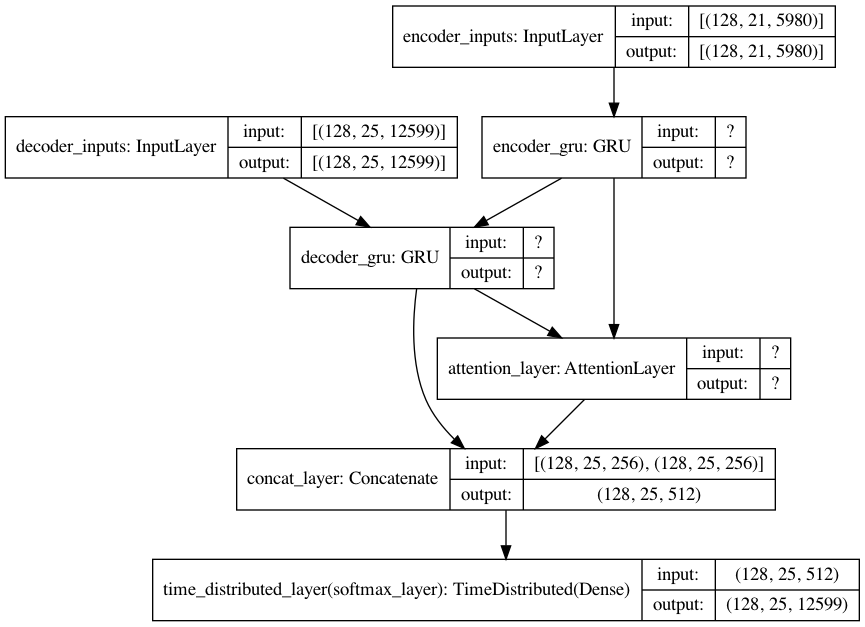

In [30]:
from keras.utils import plot_model
plot_model(full_model, show_shapes=True)

In [10]:
# %%time

# train(full_model, en_seq, fr_seq, batch_size, n_epochs)


### Model Saving

In [11]:
# full_model.save('../../../RepositoryData/output/nmt-en-zh/nmt-en-zh-full-model.h5')
# infer_enc_model.save('../../../RepositoryData/output/nmt-en-zh/nmt-en-zh-infer-enc-model.h5')
# infer_dec_model.save('../../../RepositoryData/output/nmt-en-zh/nmt-en-zh-infer-dec-model.h5')

### Prediction

In [31]:
## load model
full_model.load_weights('../../../RepositoryData/output/nmt-en-zh/nmt-en-zh-full-model.h5')
infer_enc_model.load_weights('../../../RepositoryData/output/nmt-en-zh/nmt-en-zh-infer-enc-model.h5')
infer_dec_model.load_weights('../../../RepositoryData/output/nmt-en-zh/nmt-en-zh-infer-dec-model.h5')

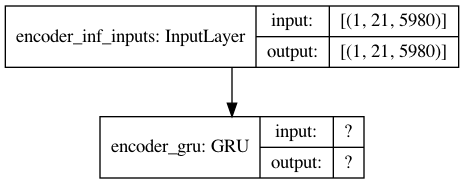

In [32]:
plot_model(infer_enc_model,show_shapes=True)

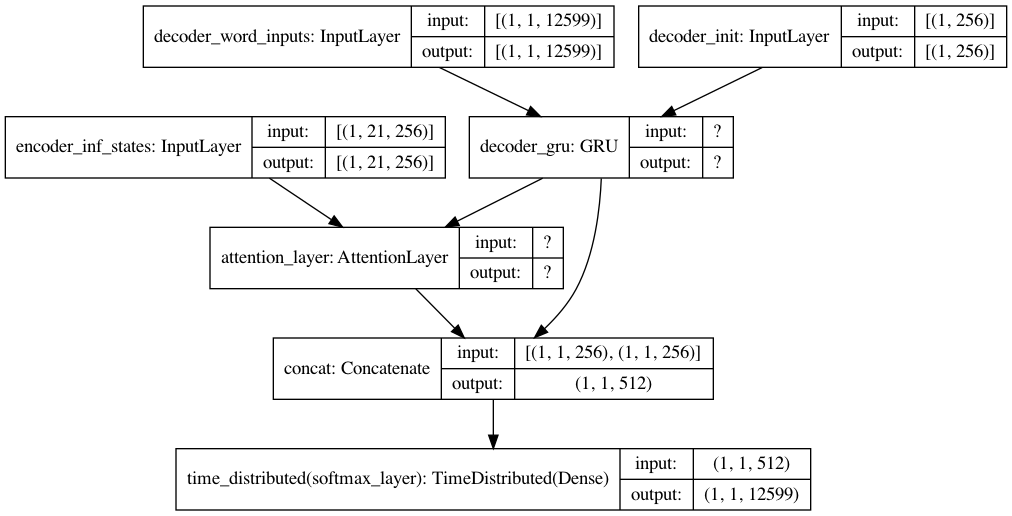

In [13]:
plot_model(infer_dec_model, show_shapes=True)

In [14]:
""" Index2word """
en_index2word = dict(
    zip(en_tokenizer.word_index.values(), en_tokenizer.word_index.keys()))
fr_index2word = dict(
    zip(fr_tokenizer.word_index.values(), fr_tokenizer.word_index.keys()))


In [15]:
def translate(infer_enc_model, infer_dec_model, test_en_text, 
              en_vsize, fr_vsize, en_timesteps, fr_timesteps,
              en_tokenizer, fr_tokenizer):
    """ Inferring with trained model """
    test_en = test_en_text
    print('Translating: {}'.format(test_en))

    test_en_seq = sents2sequences(
        en_tokenizer, [test_en], pad_length=en_timesteps)

    test_fr, attn_weights = infer_nmt(
        encoder_model=infer_enc_model, decoder_model=infer_dec_model,
        test_en_seq=test_en_seq, en_vsize=en_vsize, fr_vsize=fr_vsize, fr_timesteps = fr_timesteps)
    print('\tFrench: {}'.format(test_fr))
    return test_en_seq, test_fr, attn_weights

In [16]:
test_en_seq, test_fr, attn_weights=translate(infer_enc_model=infer_enc_model,
          infer_dec_model=infer_dec_model,
          test_en_text=ts_en_text[2],
          en_vsize=en_vsize,
          fr_vsize=fr_vsize,
          en_timesteps=en_timesteps,
          fr_timesteps=fr_timesteps,
          en_tokenizer=en_tokenizer,
          fr_tokenizer=fr_tokenizer)



Translating: She's not a child .
	French: 她 不是 個 孩子 。 eos 


In [36]:
for i in range(10):
    test_en_seq, test_fr, attn_weights=translate(infer_enc_model=infer_enc_model,
              infer_dec_model=infer_dec_model,
              test_en_text=ts_en_text[i],
              en_vsize=en_vsize,
              fr_vsize=fr_vsize,
              en_timesteps=en_timesteps,
              fr_timesteps=fr_timesteps,
              en_tokenizer=en_tokenizer,
              fr_tokenizer=fr_tokenizer)

Translating: The sky is full of stars .
	French: 天上 没有 一片 云 。 eos 
Translating: Am I wrong ?
	French: 它 是 我 的 錯 。 eos 
Translating: She's not a child .
	French: 她 不是 個 孩子 。 eos 
Translating: They all looked for the lost child .
	French: 他們 都 在 尋找 這個 走失 的 孩子 。 eos 
Translating: I didn't want to surprise you .
	French: 我 不想 跟 你 说话 。 eos 
Translating: Tom should hear about this .
	French: 汤姆 应该 告诉 那些 人 那事 。 eos 
Translating: The robot went out of control .
	French: 湯姆 開始 就 在 巴黎 。 eos 
Translating: All of us would like to get rid of nuclear weapons .
	French: 我們 所有 的 人 都 喜歡 它 。 eos 
Translating: Close your eyes .
	French: 闭上 你 的 眼睛 。 eos 
Translating: We defeated the enemy .
	French: 我们 被 要求 去 墙 。 eos 


In [37]:
ts_fr_text[:10]

['sos 天空 中 繁星点点 。 eos',
 'sos 我錯 了 嗎 ？ eos',
 'sos 她 不是 小孩 。 eos',
 'sos 他們 都 在 尋找 這個 失 蹤 的 孩子 。 eos',
 'sos 我 没想 吓唬 你 。 eos',
 'sos 汤姆 应该 听说 这个 。 eos',
 'sos 這個 機器 人 失控 了 。 eos',
 'sos 我們 所有 的 人 都 想 除掉 核子武器 。 eos',
 'sos 闭上 你们 的 眼睛 。 eos',
 'sos 我們 戰勝 了 敵人 。 eos']

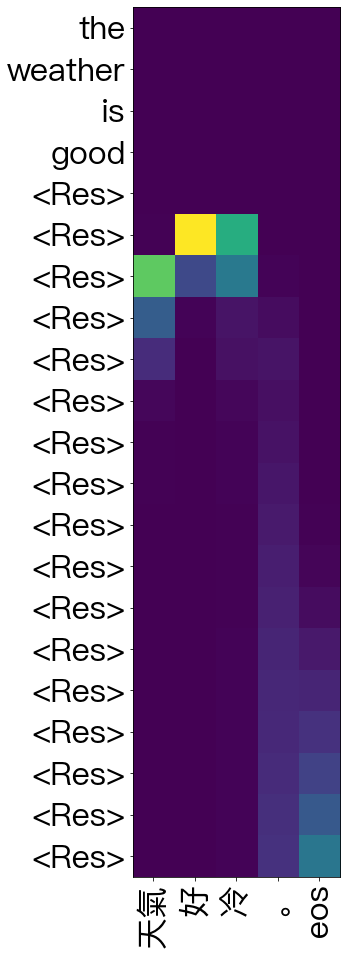

In [22]:
""" Attention plotting """
plot_attention_weights(test_en_seq, attn_weights,
                       en_index2word, fr_index2word)

In [34]:
%%time
def test(full_model, ts_enc_text, ts_dec_text, enc_tokenizer, dec_tokenizer, enc_vsize, dec_vsize, batch_size):
    # ### Getting sequence integer data
    ts_enc_seq, ts_dec_seq = preprocess_data(enc_tokenizer, dec_tokenizer, ts_enc_text, ts_dec_text)
    losses = []
    accuracies = []
    for bi in range(0, ts_enc_seq.shape[0] - batch_size, batch_size):
        enc_onehot_seq = to_categorical(
            ts_enc_seq[bi:bi + batch_size, :], num_classes=enc_vsize)
        dec_onehot_seq = to_categorical(
            ts_dec_seq[bi:bi + batch_size, :], num_classes=dec_vsize)

        # full_model.train_on_batch(
        #     [enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :])
        l,a = full_model.evaluate([enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :],
                                batch_size=batch_size, verbose=0)
        losses.append(l)
        accuracies.append(a)
    print('Average Loss:{}'.format(np.mean(losses)))
    print('Average Accuracy:{}'.format(np.mean(accuracies)))

test(full_model, ts_enc_text = ts_en_text, ts_dec_text = ts_fr_text, 
     enc_tokenizer = en_tokenizer, dec_tokenizer = fr_tokenizer, enc_vsize = en_vsize, dec_vsize = fr_vsize, batch_size = batch_size)

Average Loss:0.016041998987691135
Average Accuracy:0.996245436859827
CPU times: user 13min 18s, sys: 30.6 s, total: 13min 49s
Wall time: 4min 47s
